In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm 
import os

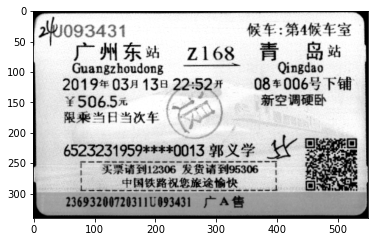

In [2]:
att_img = "tickets/0026.bmp"
att_img = cv2.imread(att_img, cv2.IMREAD_GRAYSCALE)

plt.imshow(att_img, cmap='gray')

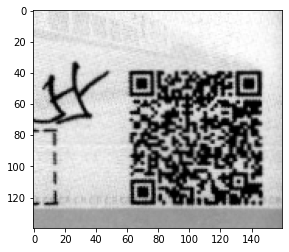

In [3]:
r, c = att_img.shape
crop_img = att_img[int(r*0.5):r-30, int(c*0.7): c-5] # 裁剪比例，右下角约八分之一

plt.imshow(crop_img, cmap='gray')

In [ ]:
blurred_img = cv2.medianBlur(crop_img, 7)

blurred_img = 255 - blurred_img
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (15, 15))
morphed = cv2.morphologyEx(blurred_img, cv2.MORPH_OPEN, kernel)
top_hat = 255 - cv2.subtract(blurred_img, morphed)

plt.imshow(top_hat, cmap='gray')


In [ ]:
# _, thres_img = cv2.threshold(top_hat, np.max(top_hat) * 0.5, 255, cv2.THRESH_BINARY)
# thres_img = cv2.adaptiveThreshold(top_hat, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 15, 2)

kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (15, 15))
morphed_img = cv2.morphologyEx(top_hat, cv2.MORPH_OPEN, kernel)

kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (15, 15))
morphed_img = cv2.morphologyEx(morphed_img, cv2.MORPH_CLOSE, kernel)

_, morphed_img = cv2.threshold(morphed_img, np.max(morphed_img) * 0.8, 255, cv2.THRESH_BINARY)

morphed_img = np.pad(morphed_img, ((0, 2), (0, 2)),'constant', constant_values=(255,255))

plt.imshow(morphed_img, cmap='gray')

In [ ]:
canny = cv2.Canny(morphed_img, 80, 150)

contour_img = cv2.cvtColor(crop_img, cv2.COLOR_GRAY2BGR)
contours, _ = cv2.findContours(canny, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contour_img = cv2.drawContours(contour_img, contours, -1, (255, 0, 0), 1)


plt.imshow(canny, cmap='gray')

In [ ]:
max_contour ,max_area = 0, 0
for contour in contours:
    tmp = cv2.contourArea(contour)
    if tmp > max_area:
        max_contour, max_area = contour, tmp

max_contour = max_contour.squeeze()
maxx, maxy = np.max(max_contour, axis=0) + 8
minx, miny = np.min(max_contour, axis=0) - 8
print(minx, maxx, miny, maxy)

In [ ]:
# lines = cv2.HoughLines(canny, 1, np.pi / 180, 10) # 参数
# lines = lines.squeeze()
# print(lines.shape)

# fetch_lines = fetch_line(lines)
# left, right, up, down = *fetch_lines[0], *fetch_lines[1]

res_img = crop_img[miny:maxy, minx:maxx]
plt.imshow(res_img, cmap='gray')


--------
操作汇总
--------

In [ ]:
# 从lines中合并出矩形的四条直线
# python霍夫变换输出直线的顺序是点从多到少
def fetch_line(lines, shape):
    lines = abs(lines) # 对rho取绝对值
    line_num = 4 # 横竖各考虑2条干扰线，太多会引入误差，太少容易漏掉真边
    standard_shape = 90 # 设定二维码标准长宽
    fetch_lines = np.zeros((2, line_num)) 
    cnt = [0, 0]
    for rho, theta in lines:
        mode = 0
        if theta < np.pi / 180 * 5 or np.pi - theta < np.pi / 180 * 5: # 竖线
            mode = 0
        elif abs(theta - np.pi / 2) < np.pi / 180 * 5: # 横线
            mode = 1
        else:
            continue
        if cnt[mode] >= line_num:
            continue

        for i in range(cnt[mode]):
            r = fetch_lines[mode][i]
            if abs(rho - r) <= 15: # 认为是同一条线，rho取更外围的值
                if rho > shape[0]/2 and rho > r:
                    fetch_lines[mode][i] = rho
                elif rho < shape[0]/2 and rho < r:
                    fetch_lines[mode][i] = rho
                break
        else:
            fetch_lines[mode][cnt[mode]] = rho
            cnt[mode] += 1

    # 取相邻两边距离最接近standard_shape的一对边
    fetch_lines = np.sort(fetch_lines, axis=1)
    # print("sorted:", fetch_lines)
    result = np.zeros((2, 2))
    for mode in range(2):
        min = standard_shape
        for i in range(line_num):
            if fetch_lines[mode, i] == 0: continue
            for j in range(i+1, line_num):
                dis = fetch_lines[mode, j] - fetch_lines[mode, i] - standard_shape 
                if dis > 0 and dis < min:
                    min = dis
                    result[mode] = [fetch_lines[mode, i], fetch_lines[mode, j]]
    
    # print(result)
    return np.uint8(result)

In [ ]:
def extract_qr_old(att_img):
    # 裁剪，右下角约八分之一
    r, c = att_img.shape
    crop_img = att_img[int(r*0.5):r-30, int(c*0.7): c-5]

    # 滤波、二值化
    blurred_img = cv2.medianBlur(crop_img, 7)
    _, thres_img = cv2.threshold(blurred_img, max(blurred_img.reshape(-1)) * 0.5, 255, cv2.THRESH_BINARY)  

    # 形态学处理
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (15, 15))
    morphed_img = cv2.morphologyEx(thres_img, cv2.MORPH_OPEN, kernel)

    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (20, 20))
    morphed_img = cv2.morphologyEx(morphed_img, cv2.MORPH_CLOSE, kernel)

    # 霍夫变换
    canny = cv2.Canny(morphed_img, 80, 150)
    lines = cv2.HoughLines(canny, 1, np.pi / 180, 10) # 参数
    lines = lines.squeeze()

    # 求解四条边界
    fetch_lines = fetch_line(lines, canny.shape)
    left, right, up, down = *fetch_lines[0], *fetch_lines[1]

    res_img = crop_img[up-2:down+2, left-2:right+2]
    return res_img

In [ ]:
def extract_qr(att_img, img_name):
    # 裁剪，右下角约八分之一
    r, c = att_img.shape
    crop_img = att_img[int(r*0.5):r-30, int(c*0.7): c-5]

    blurred_img = cv2.medianBlur(crop_img, 7)
    blurred_img = 255 - blurred_img
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (15, 15))
    morphed = cv2.morphologyEx(blurred_img, cv2.MORPH_OPEN, kernel)
    top_hat = 255 - cv2.subtract(blurred_img, morphed)

    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (15, 15))
    morphed_img = cv2.morphologyEx(top_hat, cv2.MORPH_OPEN, kernel)

    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (15, 15))
    morphed_img = cv2.morphologyEx(morphed_img, cv2.MORPH_CLOSE, kernel)

    _, morphed_img = cv2.threshold(morphed_img, np.max(morphed_img) * 0.8, 255, cv2.THRESH_BINARY)
    morphed_img = np.pad(morphed_img, ((0, 2), (0, 2)),'constant', constant_values=(255,255))

    canny = cv2.Canny(morphed_img, 80, 150)
    contours, _ = cv2.findContours(canny, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    max_contour ,max_area = 0, 0
    for contour in contours:
        tmp = cv2.contourArea(contour)
        if tmp > max_area:
            max_contour, max_area = contour, tmp

    max_contour = max_contour.squeeze()
    maxx, maxy = np.max(max_contour, axis=0) + 8
    minx, miny = np.min(max_contour, axis=0) - 8

    res_img = crop_img[miny:maxy, minx:maxx]

    if not (res_img.shape[1]>0 and res_img.shape[0] / res_img.shape[1] > 0.9 and res_img.shape[0] / res_img.shape[1] < 1.1):
        fail_list.append(img_name)
        att2_img = extract_qr_old(att_img)
        if att2_img.shape[0]>0 and att2_img.shape[1]>0:
            return att2_img
    return res_img

In [ ]:
input_path = "./tickets"
output_path = "./qr"

if not os.path.exists(output_path):
    os.mkdir(output_path)

fail_list = []
for file_name in tqdm(os.listdir(input_path)):
    try:
        img = cv2.imread(os.path.join(input_path, file_name), cv2.IMREAD_GRAYSCALE)
        qr_img = extract_qr(img, file_name)
        cv2.imwrite(os.path.join(output_path, file_name), qr_img)
    except Exception as e:
        print("\nFail at {}: {} skipped".format(file_name, e.args[0]))
print('\ndone!')
print('Following pictures were failed with new algorithm. Old algorithm was applied:')
for name in fail_list:
    print(name)